## Learning to read emotions in words using a Semi-Supervised Variational Autoencoder

In this example, we use a semi-supervised variant of the VAE to train the model with emotion ratings as well.

This example is adapted from the Pyro [SSVAE Tutorial](http://pyro.ai/examples/ss-vae.html)

The difference from the normal VAE is that now there is an additional observed **Emotion Ratings**. The parameters $\theta$ now parameterize the transformation from **ratings** and $z$ to **word embeddings** $p_{\theta}(\text{embedding}| \text{ rating}, z)$.

One way to think about this model, coming from the VAE, is that the addition of the emotion ratings will encourage the model to learn $\theta$ that reflect variance in the word embeddings due to emotions.

This model is a **semi-supervised variant of the VAE**, or SSVAE (Kingma et al, 2014; Siddharth et al, 2017).
We discuss the SSVAE formulation at a high level, below, and we invite the interested reader to check the reference list at the bottom for the more theoretical details of inference in the SSVAE.) 

We will be using the same Dataset as before: we have a set of (Face, Rating) paired observations (with ~18 unique faces) and a set of 203 unlablled Faces we used for the VAE. 

### Semi-supervised VAE

The model is similar to the VAE in that there are `encoders` and `decoders`. The main difference is that, in addition to the `decoder`, there are now 2 `encoders`:

- `decoder` "goes from" the (latent $z$ and ratings) to word embeddings, i.e. $p_\theta(\text{embedding }|z, \text{ratings})$)
- `encoder_y` "goes from" the embedding to the ratings, i.e., $q(\text{ratings } | \text{ embedding})$
- `encoder_z` "goes from" (embedding and ratings) to the latent $z$, i.e., $q(z, | \text{ ratings, embedding})$

In our SSVAE model, we have a ``.model()`` and ``.guide()`` that are similar to the VAE: they define the reconstruction loss that the model is trained against (Kingma & Welling, 2014). 

We add an additional ``.model_rating()`` and ``.guide_rating()`` to add a "supervised" loss to guide the model to learn from the supervised examples (Kingma et al, 2014).

```
class SemiSupervisedVAE():
    def model(self, emotion, embedding):
        # condition on the observed data
        emo = pyro.sample("emo", Normal(emo_prior_loc, emo_prior_scale), obs=emotion)
        # sample z given priors
        z = pyro.sample("z", dist.Normal(prior_location, prior_scale))
        # generate the face using emotion and z, and condition on observed image
        loc = self.decoder(torch.cat((z, emo), 1))           
        pyro.sample("word", dist.Bernoulli(loc), obs=embedding)
        
    def model_rating(self, embedding, emotion=None):
        # Extra term to yield an auxiliary loss that we do gradient descent on
        if emotion is not None:
            emo_mean, emo_scale = self.encoder_y(embedding)
            pyro.sample("emo_aux", dist.Normal(emo_mean, emo_scale), obs=emotion)

```

##### Preamble

This first chunk of code imports the necessary python packages and functions that we will use

In [30]:
#from __future__ import division, print_function, absolute_import
from __future__ import print_function

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


from torchvision import transforms, utils, datasets
from torchvision.transforms import ToPILImage
from skimage import io, transform
from scipy.special import expit
from PIL import Image
from matplotlib.pyplot import imshow

from pyro.contrib.examples.util import print_and_log, set_seed
import pyro.poutine as poutine
# custom helperCode for this tutorial, in helperCode.py
import helperCode
from utils.custom_mlp import MLP, Exp


from visdom import Visdom

#from utils.vae_plots import plot_llk, plot_vae_samples
from utils.mnist_cached import  mkdir_p, setup_data_loaders
from utils.vae_plots import plot_conditional_samples_ssvae, plot_vae_samples

EMBED_SIZE = 50
IMG_WIDTH = 100
IMG_SIZE = IMG_WIDTH*IMG_WIDTH*3
BATCH_SIZE = 32
DEFAULT_HIDDEN_DIMS = [100, 100] # [200,200] #[500, 500]
DEFAULT_Z_DIM = 10 # 50 #2

#### Word embeddings

Now we will load the GloVe word embeddings. (Warning: may take up to a minute...)

In [6]:
embed_path = os.path.join(os.path.abspath('..'), "glove", "glove.6B.50d.txt")

def load_glove_embeddings(path):
    print("Loading GloVe embeddings")
    with open(path,'r') as f:
        model = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
        print("Done.",len(model)," words loaded!")
        return model

embeddings = load_glove_embeddings(embed_path)

Loading GloVe embeddings
Done. 400000  words loaded!


#### Dataset

We will using dataset with only utterances and emotion ratings. Here are the utterances used in the experiment:



In [72]:
# Data location
dataset_path = os.path.join(os.path.abspath(".."), "CognitionData", "dataSecondExpt_utteranceOnly.csv")
expdata = pd.read_csv(dataset_path)

# Print utterances
utterances = list(sorted(pd.unique(expdata.loc[:]["utterance"])))
print(utterances)


['awesome', 'cool', 'damn', 'dang', 'man', 'meh', 'oh', 'wow', 'yay', 'yikes']


This next chunk defines a function to read in the data, and stores the data in `word_emotion_dataset`. Each observation consists of a 8-dimensional emotion rating vector and an accompanying word embedding.

In [100]:
class WordEmotionDataset(Dataset):
    """Word emotion dataset."""
    
    def __init__(self, csv_file, embeddings, transform=None):
        """
        Args:
            csv_file (string): Path to the experiment csv file 
            embeddings (dict): Dictionary of pre-trained word embeddings.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.expdata = pd.read_csv(csv_file)
        self.embeddings = embeddings
        self.transform = transform

    def __len__(self):
        return len(self.expdata)

    def __getitem__(self, idx):
        # Load and normalize the emotion data
        emotions = np.array(self.expdata.iloc[idx]["happy":"disapp"], np.float32)
        emotions = (emotions-1)/8
        
        word = self.expdata.iloc[idx]["utterance"]
        try:
            embed = self.embeddings[word]
            if self.transform:
                embed = self.transform(embed)
        except:
            print(word)
            raise

        return embed, emotions

# Transform to Tensor for use by PyTorch
data_transform = torch.from_numpy

# Read in datafile.
print("Reading in dataset...")

word_emotion_dataset = WordEmotionDataset(csv_file=dataset_path, 
                                          embeddings=embeddings, 
                                          transform=data_transform)
word_emotion_loader = torch.utils.data.DataLoader(word_emotion_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True,
                                                  num_workers=4)

N_samples = len(word_emotion_dataset)
print("Number of observations:", N_samples)

# Taking a sample observation
embed1, emo1 = word_emotion_dataset[np.random.randint(0, N_samples)]
print("Sample Observation: ")
# print("Utterance:", word1)
print("Embedding:")
print(embed1)
print("Ratings:")
for k, v in zip(helperCode.EMOTION_VAR_NAMES, emo1):
    print("{:10}:   {}".format(k,v))

Reading in dataset...
Number of observations: 495
Sample Observation: 
Embedding:
tensor([-0.3506, -0.6451,  0.0278, -0.1339,  0.0142, -1.4423,  0.5744,
        -0.1708, -0.1624, -0.1450, -0.5040, -0.4346,  0.0917, -0.7354,
         0.0677, -0.6634,  0.6884,  1.0008,  0.4845,  0.6128, -0.6673,
        -0.5989,  0.2893,  0.3741,  1.3327, -0.6727, -0.7735,  0.4228,
        -0.5093, -1.0273,  0.1071, -0.1422,  0.1344,  1.2473, -0.4950,
        -0.2869,  0.1091,  0.9635,  0.2762,  1.0672, -0.5012,  0.4027,
        -0.2212, -0.4713,  0.6056, -1.1590, -0.1890, -0.4710,  1.0820,
         0.7326], dtype=torch.float64)
Ratings:
happy     :   0.25
sad       :   0.75
anger     :   0.125
surprise  :   0.375
disgust   :   0.625
fear      :   0.125
content   :   0.25
disapp    :   0.875


Now we load dataset of additional exclamation words for unsupervised learning.

In [101]:
class WordDataset(Dataset):
    """Random word dataset."""
    
    def __init__(self, csv_file, embeddings, transform=None):
        """
        Args:
            size (int): Number of random words to use 
            embeddings (dict): Dictionary of pre-trained word embeddings.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.words = pd.read_csv(csv_file, header=None)
        self.embeddings = embeddings
        self.transform = transform

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        # Load and normalize the emotion data        
        word = self.words.iloc[idx][0]
        try:
            embed = self.embeddings[word]
            if self.transform:
                embed = self.transform(embed)
        except:
            print(word)
            raise

        return embed, None

exclamations_path = os.path.join(os.path.abspath(".."), "CognitionData", "exclamations.csv")
more_words_dataset = WordDataset(csv_file=exclamations_path, 
                                 embeddings=embeddings,
                                 transform=data_transform)
more_words_loader = torch.utils.data.DataLoader(more_words_dataset,
                                                batch_size=BATCH_SIZE, shuffle=True,
                                                num_workers=4)

print("Number of observations:", len(more_words_dataset))

# Taking a sample observation
embed2 = more_words_dataset[np.random.randint(0, len(more_words_dataset))]
print("Sample Observation: ")
# print("Utterance:", word2)
print("Embedding:")
print(embed2)

# Define dictionary of data loaders
data_loaders = {"supervised": word_emotion_loader , "unsupervised": more_words_loader }

Number of observations: 121
Sample Observation: 
Embedding:
(tensor([-0.3506, -0.6451,  0.0278, -0.1339,  0.0142, -1.4423,  0.5744,
        -0.1708, -0.1624, -0.1450, -0.5040, -0.4346,  0.0917, -0.7354,
         0.0677, -0.6634,  0.6884,  1.0008,  0.4845,  0.6128, -0.6673,
        -0.5989,  0.2893,  0.3741,  1.3327, -0.6727, -0.7735,  0.4228,
        -0.5093, -1.0273,  0.1071, -0.1422,  0.1344,  1.2473, -0.4950,
        -0.2869,  0.1091,  0.9635,  0.2762,  1.0672, -0.5012,  0.4027,
        -0.2212, -0.4713,  0.6056, -1.1590, -0.1890, -0.4710,  1.0820,
         0.7326], dtype=torch.float64), None)


### Model

In [102]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks), models & guides needed to train a
    semi-supervised variational auto-encoder.
    Modified from https://github.com/uber/pyro/blob/dev/examples/vae/ss_vae_M2.py

    :param output_size: size of the tensor representing the ratings 
                        in our case, emotion ratings is an 8 dimensional vector in [0,1]
                        global constant: helperCode.EMOTION_VAR_DIM (= 8)
    :param input_size: size of the tensor representing the word embedding
                        defaults to 300 (the largest size in GloVe)
    :param z_dim: size of the tensor representing the latent random variable z
    :param hidden_layers: a tuple (or list) of MultiLayer Perceptron (MLP) layers 
                          to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, output_size=helperCode.EMOTION_VAR_DIM, input_size=EMBED_SIZE, 
                 z_dim=DEFAULT_Z_DIM, hidden_layers=DEFAULT_HIDDEN_DIMS,
                 config_enum=None, use_cuda=False, aux_loss_multiplier=None):
        super(SSVAE, self).__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier
        
        # define the neural networks used later in the model and the guide.
        # these networks are MLPs (multi-layered perceptrons or simple feed-forward networks)
        # where the provided activation parameter is used on every linear layer except
        # for the output layer where we use the provided output_activation parameter
        
        # self.encoder_y = nn.Sequential(
        #       nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False)
        # )

        
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim, z_dim]
        # to produce a mean and scale parameter for a Normal distribution, 
        # and we can apply different activations [None, Exp] on them

        # encoder_y goes from embeddings to ratings
        self.encoder_y = MLP([self.input_size] +
                             self.hidden_layers + 
                             [[self.output_size, self.output_size]],
                             activation=nn.Tanh,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # encoder_z goes from [embeddings, ratings] to z
        self.encoder_z = MLP([self.input_size + self.output_size] +
                             self.hidden_layers + [[z_dim, z_dim]],
                             activation=nn.ReLU,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # decoder goes from [z, emotion ratings] to the embedding.
        self.decoder = MLP([z_dim + self.output_size] +
                           self.hidden_layers[::-1] +
                           [[self.input_size, self.input_size]],
                           activation=nn.ReLU,
                           output_activation=nn.Sigmoid,
                           allow_broadcast=self.allow_broadcast,
                           use_cuda=self.use_cuda)
        
        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()
            
    def model(self, xs, ys=None, beta=1.0):
        """
        The model corresponds to the following generative process:
        p(z)     = normal(0,I)              # Prior on the latent variable z
        p(y)     = normal(.5, .05)          # Emotion Rating corresponding to word embedding
        p(x|y,z) = normal(decoder(y,z))  # Producing an image
                                              decoder is a neural network

        :param xs: a batch of word embeddings
        :param ys: (optional) a batch of emotion ratings.
                   if ys is not provided, will treat as unsupervised, sample from prior.
        :param beta: scale parameter that weights the KL divergence in the ELBO
                     also sometimes called annealing.
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ssvae", self)

        batch_size = xs.size(0)
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):

            # sample the latent z from the (constant) prior, z ~ Normal(0,I)
            z_prior_mean  = torch.zeros(size=[batch_size, self.z_dim])
            z_prior_scale = torch.exp(torch.zeros(size=[batch_size, self.z_dim]))
            with poutine.scale(scale=beta):
                zs = pyro.sample("z", dist.Normal(z_prior_mean, z_prior_scale).independent(1))

            # if the label y (emotion rating) is not provided, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            y_prior_mean  = torch.ones(size=[batch_size, self.output_size]) *0.5 #/ (1.0 * self.output_size)
            y_prior_scale = torch.ones(size=[batch_size, self.output_size]) *0.05
            if ys is None:
                ys = pyro.sample("y", dist.Normal(y_prior_mean, y_prior_scale).independent(1))
            else:
                ys = pyro.sample("y", dist.Normal(y_prior_mean, y_prior_scale).independent(1), obs=ys)
                
            # Finally, we can condition on observing the word embedding,
            #    using the latent z and emotion rating y in the 
            #    parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            #    where decoder is a neural network
            
            x_mean, x_scale = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Normal(x_mean, x_scale).independent(1), obs=xs)
            
            # return the mean and variance of the word embedding distribution
            return x_mean, x_scale

    def guide(self, xs, ys=None, beta=1.0):
        """
        The guide corresponds to the following:
        q(y|x)   = normal(encoder_y(x))   # infer emotion rating from word embedding
        q(z|x,y) = normal(encoder_z(x,y)) # infer z from embedding and the emotion rating

        :param xs: a batch of word vectors
        :param ys: (optional) a batch of emotion ratings.
                   if ys is not provided, will treat as unsupervised
        :param beta: not used here, but left to match the call signature of self.model()
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):

            # if the emotion rating is not provided, 
            #    sample with the variational distribution
            #    q(y|x) = Normal(encoder_y(x))
            if ys is None:
                y_mean, y_scale = self.encoder_y.forward(xs)
                #scale_ys = xs.new_ones([batch_size, self.output_size])*0.05
                ys = pyro.sample("y", dist.Normal(y_mean, y_scale).independent(1))
                
            # Sample (and score) the latent z with the variational
            #   distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            #   where loc(.), scale(.) are given by encoder_z()
                        
            z_mean, z_scale = self.encoder_z.forward([xs, ys])
            with poutine.scale(scale=beta): 
                pyro.sample("z", dist.Normal(z_mean, z_scale).independent(1))

    def model_rating(self, xs, ys=None, beta=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in
        Kingma et al. (2014), "Semi-Supervised Learning with Deep Generative Models".
        
        This is to ensure that the model learns from the supervised examples.
        q(y|x) = normal(encoder_y(x))
        
        :param xs:   word embedding
        :param ys:   emotion rating
        :param beta: not used here, but left to match the call signature of self.model()
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ssvae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):
            # this is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                y_mean, y_scale = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.Normal(y_mean, y_scale).independent(1), obs=ys)

    def guide_rating(self, xs, ys=None, beta=None):
        """
        dummy guide function to accompany model_rating() in inference
        This guide function is empty, because model_rating() has no latent random variables
        (i.e., model_rating() has no pyro.sample() calls that are not conditioned on observations)
        """
        pass
    
    # define a helper function to assign ratings to faces
    def rate(self, xs):
        """
        assign emotion ratings (ys) to a word embedding (or a batch of them)

        :param xs: a batch of word vectors
        :return:   a batch of the corresponding emotion ratings (ys)
        """
        # use the trained model q(y|x) = normal(encoder_y(x))
        # compute the emotion ratings for the image(s)
        y_mean, y_scale = self.encoder_y.forward(xs)
        return y_mean
    
    # define a helper function for reconstructing word vectors
    def reconstruct_word(self, x):
        # encode word vector x. This function assumes that x is a single vector, 
        # but as the encoders and decoders take in batches, we have to resize x:
        xs = x.view(1, EMBED_SIZE)
        y_mean, y_scale = self.encoder_y.forward(xs)
        ys = dist.Normal(y_mean, y_scale).sample()
        z_mean, z_scale = self.encoder_z.forward([xs, ys])
        # sample in latent space
        zs = dist.Normal(z_mean, z_scale).sample()
        # decode the word (note we don't sample in the word embedding space)
        x_mean, x_scale = self.decoder([zs, ys])
        return x_mean

#### Training

Next we define the parameters of our training session, and set up the model and inference algorithm. This part is identical to the linear regression and VAE example.

The key difference is that we have 2 losses. 

- The unsupervised loss from the vanilla VAE, which is captured by ```loss_basic = SVI(ssvae.model, ssvae.guide, optimizer, loss=Trace_ELBO())``` 
- and the supervised loss, or auxillary loss, captured by ```loss_aux = SVI(ssvae.model_rating, ssvae.guide_rating, optimizer, loss=Trace_ELBO())```

At each loop in the training, we take one "basic" step and one "auxillary" step, to train the model with both losses together.

Since the training takes a while, `num_epochs` below is set to 1 just to demonstrate training (and it still might take a while!). Ideally you'll want to train for much longer.

In [103]:
class Args:
    learning_rate = 5e-6#5e-4
    num_epochs = 1 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    seed = 1
    beta_1 = 0.900
    aux_loss = True 
    aux_loss_multiplier = 10 #50.0
    cuda = False
    # enum_discrete = None #"parallel"#"sequential" #"parallel"
    #visdom_flag = True
    #visualize = True
    #logfile = "./tmp.log"
    
args = Args()


pyro.clear_param_store()

unsup_num = len(more_words_dataset)
sup_num = len(word_emotion_dataset)


if args.seed is not None:
    set_seed(args.seed, args.cuda)

# batch_size: number of images (and labels) to be considered in a batch
ssvae = SSVAE(output_size=helperCode.EMOTION_VAR_DIM, input_size=EMBED_SIZE, 
              z_dim=args.z_dim,
              hidden_layers=args.hidden_layers,
              use_cuda=args.cuda,
              #config_enum=args.enum_discrete,
              aux_loss_multiplier=args.aux_loss_multiplier)

# setup the optimizer
adam_params = {"lr": args.learning_rate, "betas": (args.beta_1, 0.999)}
optimizer = Adam(adam_params)

# set up the loss(es) for inference. 

## wrapping the guide in config_enumerate builds the loss as a sum
## by enumerating each class label for the sampled discrete categorical distribution in the model
##guide = config_enumerate(ssvae.guide, args.enum_discrete)
##loss_basic = SVI(ssvae.model, guide, optimizer, loss=TraceEnum_ELBO(max_iarange_nesting=2))

loss_basic = SVI(ssvae.model, ssvae.guide, optimizer, loss=Trace_ELBO())

# build a list of all losses considered
losses = [loss_basic]

# aux_loss: whether to use the auxiliary loss from (Kingma et al, 2014 NIPS paper)
if args.aux_loss:
    loss_aux = SVI(ssvae.model_rating, ssvae.guide_rating, optimizer, loss=Trace_ELBO())
    losses.append(loss_aux)

#### Setting up Inference

This next chunk defines some helper functions to help run the inference

In [104]:
def getBeta(epoch, gamma=1e-2, c=800):
    # this is a helper function to compute an annealing parameter beta for a given epoch.
    # beta starts off near 0 and gradually increases, reaching 1 at epoch=c
    return float(expit(gamma*(epoch - c)))

def run_inference_for_epoch(data_loaders, losses, epoch, gamma=1e-2, c=800, cuda=False):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    # don't use all the sup_batches
    sup_batches = 20
    #sup_batches = len(data_loaders["supervised"])
    unsup_batches = len(data_loaders["unsupervised"])
    batches_per_epoch = sup_batches + unsup_batches

    # initialize variables to store loss values
    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["supervised"])
    unsup_iter = iter(data_loaders["unsupervised"])

    # random order
    is_sups = [1]*sup_batches + [0]*unsup_batches
    is_sups = np.random.permutation(is_sups)
    
    # annealing factor
    beta = getBeta(epoch, gamma, c)
    
    for i in range(batches_per_epoch):
        #if i%10 == 0:
        #    print("Epoch", epoch, ": on batch", i, "out of", batches_per_epoch)
        # whether this batch is supervised or not
        is_supervised = is_sups[i]
        
        # extract the corresponding batch
        if is_supervised:
            xs, ys = next(sup_iter)
        else:
            xs, ys = next(unsup_iter)

        if cuda:
            ys = ys.cuda()
            xs = xs.cuda()
        
        batchsize = xs.size(0)
        xs = xs.view(batchsize, -1)
        
        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            if is_supervised:
                new_loss = losses[loss_id].step(xs, ys, beta=beta)
                epoch_losses_sup[loss_id] += new_loss
            else:
                new_loss = losses[loss_id].step(xs, beta=beta)
                epoch_losses_unsup[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses_sup, epoch_losses_unsup

def get_prediction_error(data_loader, rating_fn):
    """
    compute the prediction error over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    for (xs, ys) in data_loader:
        # use classification function to compute all predictions for each batch
        batchsize = xs.size(0)
        xs = xs.view(batchsize, -1)
        ys = ys.view(batchsize, -1)
        predictions.append(rating_fn(xs))
        actuals.append(ys)
        
    #abs(predictions[i] - actuals[i]) for i in range(len(predictions))

    predErrors = [abs(pred_i - act_i) for pred_i, act_i in zip(predictions, actuals)]
    meanPredError = sum([torch.sum(pe) for pe in predErrors]) / (len(predictions) * BATCH_SIZE * helperCode.EMOTION_VAR_DIM)

    return meanPredError, predictions, actuals

#### Training loop

This next chunk of code runs the training over `num_epochs` epochs.

In [105]:
try:
    # run inference for a certain number of epochs
    for i in range(0, args.num_epochs):

        # get the losses for an epoch
        epoch_losses_sup, epoch_losses_unsup = \
            run_inference_for_epoch(data_loaders, losses, epoch=i, cuda=args.cuda)

        # compute average epoch losses i.e. losses per example
        avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
        avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup)

        # store the loss and validation/testing accuracies in the logfile
        #str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
        #str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))
        str_loss_sup = "Supervised Recon Loss: " + str(avg_epoch_losses_sup[0]) + \
        "\n     Auxillary Loss: " + str(avg_epoch_losses_sup[1])
        str_loss_unsup = "\n     Unsupervised Recon Loss: " + str(avg_epoch_losses_unsup[0])

        str_print = "Epoch {} : Avg {}".format(i, "{} {}".format(str_loss_sup, str_loss_unsup))
        
        predErr, _, _ = get_prediction_error(data_loaders["supervised"], ssvae.rate)
        str_print += "\n     Train set prediction error: {}".format(predErr)
        print(str_print)
finally:
    print("Done")


Done


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fbfbf472b10>> ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fbfbcf71890>> ignored


RuntimeError: Expected a Tensor of type torch.DoubleTensor but found a type torch.FloatTensor for sequence element 1  in sequence argument at position #1 'tensors'

Because the model above takes a while to train, you can use the following two chunks to save or load a model. We assume that you'll skip this save step and load the model from `trained_models`.

In [9]:
# save model
savemodel = False
if savemodel:
    pyro.get_param_store().save('trained_models/ssvae_pretrained.save')

In [10]:
loadmodel = True
if loadmodel:
    pyro.get_param_store().load('trained_models/ssvae_pretrained.save')
    pyro.module("ssvae", ssvae, update_module_params=True)

In [11]:
pyro.get_param_store().get_all_param_names()

['ssvae$$$encoder_y.sequential_mlp.3.bias',
 'ssvae$$$decoder.sequential_mlp.3.weight',
 'ssvae$$$encoder_y.sequential_mlp.1.bias',
 'ssvae$$$decoder.sequential_mlp.1.weight',
 'ssvae$$$decoder.sequential_mlp.3.bias',
 'ssvae$$$encoder_z.sequential_mlp.5.1.0.bias',
 'ssvae$$$encoder_y.sequential_mlp.1.weight',
 'ssvae$$$encoder_z.sequential_mlp.5.0.0.weight',
 'ssvae$$$encoder_y.sequential_mlp.5.0.0.bias',
 'ssvae$$$encoder_y.sequential_mlp.3.weight',
 'ssvae$$$encoder_z.sequential_mlp.5.0.0.bias',
 'ssvae$$$encoder_z.sequential_mlp.3.weight',
 'ssvae$$$encoder_z.sequential_mlp.1.weight',
 'ssvae$$$encoder_y.sequential_mlp.5.0.0.weight',
 'ssvae$$$encoder_z.sequential_mlp.5.1.0.weight',
 'ssvae$$$encoder_y.sequential_mlp.5.1.0.weight',
 'ssvae$$$decoder.sequential_mlp.5.bias',
 'ssvae$$$encoder_y.sequential_mlp.5.1.0.bias',
 'ssvae$$$decoder.sequential_mlp.1.bias',
 'ssvae$$$encoder_z.sequential_mlp.1.bias',
 'ssvae$$$encoder_z.sequential_mlp.3.bias',
 'ssvae$$$decoder.sequential_mlp.5

Reconstruct images

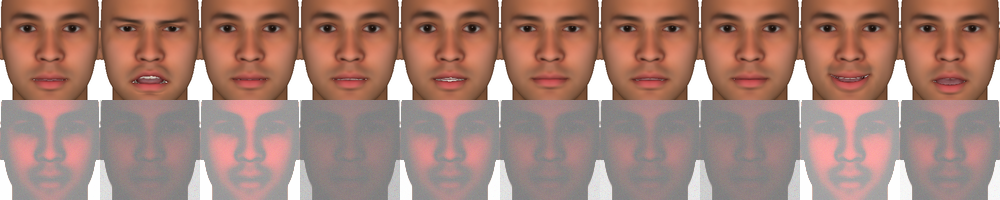

In [13]:
NUM_SAMPLES = 10
input_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")

for i, (x, _) in enumerate(more_faces_loader):
    # pick NUM_SAMPLES random test images from the first mini-batch and
    # visualize how well we're reconstructing them
    if i == 0:
        reco_indices = np.random.randint(0, x.size(0), NUM_SAMPLES)
        for index in reco_indices:
            input_img = x[index, :]
            # storing the input image
            input_img_display = np.array(input_img*255., dtype='uint8')
            input_img_display = input_img_display.transpose((1, 2, 0))
            input_array = np.concatenate((input_array, input_img_display), axis=1)

            # generating the reconstructed image and adding to array
            reconstructed_img = ssvae.reconstruct_img(input_img)
            reconstructed_img = reconstructed_img.view(3, IMG_WIDTH, IMG_WIDTH).detach().numpy()
            reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
            reconstructed_img = reconstructed_img.transpose((1, 2, 0))
            reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
Image.fromarray(display_array)

-----

Written by: Desmond Ong (desmond.c.ong@gmail.com) and Harold Soh (hsoh@comp.nus.edu.sg)

References:

Pyro [VAE tutorial](http://pyro.ai/examples/vae.html), [SSVAE tutorial](http://pyro.ai/examples/ss-vae.html)

Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. (2013). Stochastic
variational inference. *The Journal of Machine Learning Research*, 14(1),
1303-1347.

Kingma, D. P., Mohamed, S., Rezende, D. J., & Welling, M. (2014). Semi-supervised learning with deep generative models. In *Advances in Neural Information Processing Systems*, pp. 3581-3589. https://arxiv.org/abs/1406.5298

Kingma, D. P., & Welling, M. (2014). Auto-encoding variational bayes. Auto-Encoding Variational Bayes. In *The International Conference on Learning Representations*. https://arxiv.org/abs/1312.6114


Narayanaswamy, S., Paige, T. B., van de Meent, J. W., Desmaison, A., Goodman, N. D., Kohli, P., Wood, F. & Torr, P. (2017). Learning Disentangled Representations with Semi-Supervised Deep Generative Models. In *Advances in Neural Information Processing Systems*, pp. 5927-5937. https://arxiv.org/abs/1706.00400

Data from https://github.com/desmond-ong/affCog, from the following paper:

Ong, D. C., Zaki, J., & Goodman, N. D. (2015). Affective Cognition: Exploring lay theories of emotion. *Cognition*, 143, 141-162.